In [1]:
import torch as t
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from metrics import accuracy
NUM_CLASS = 4
SEED = 42
NUM_FEATURES = 2

## 1. Create a toy multi-class dataset

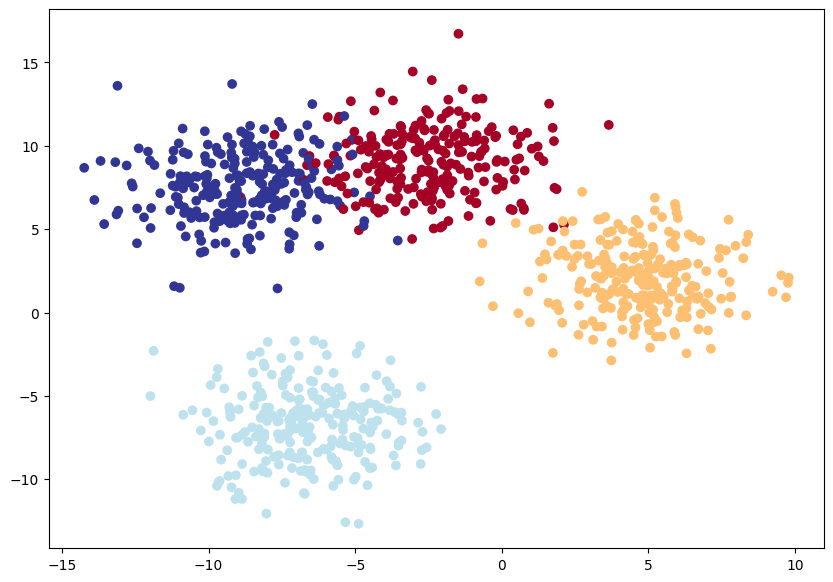

In [2]:
# create
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASS,
                            cluster_std=2,
                            random_state=SEED)

# convert to tensor
X_blob, y_blob = t.from_numpy(X_blob).type(t.float32), t.from_numpy(y_blob).type(t.LongTensor)

# split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                        test_size=0.2,
                                                                        random_state=SEED)

# plot
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

## 2. Building model

In [3]:
# device agnostic code
device = 'cuda' if t.cuda.is_available() else 'cpu'

In [4]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_unit=8):
        """
        Initializé multi-class classification model.
        Args:
            input_features: number of input features
            output_features: number of classes
            hidden_unit: number of hidden unit between layer, default 8
        """
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_unit),
            nn.ReLU(),
            nn.Linear(in_features=hidden_unit, out_features=hidden_unit),
            nn.ReLU(),
            nn.Linear(in_features=hidden_unit, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [5]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [6]:
t.unique(y_blob_train)  # 4 class

tensor([0, 1, 2, 3])

## 3. Create instance of model, loss, optimizer

In [7]:
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)

model_0 = BlobModel(input_features=2, output_features=4, hidden_unit=8).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = t.optim.SGD(
    params=model_0.parameters(),
    lr=0.1
)

model_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [8]:
X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)

In [9]:
# test predict
model_0.eval()
with t.inference_mode():
    y_logits = model_0(X_blob_test)

y_logits[:10]

tensor([[-0.8118, -0.8307, -1.6751, -1.1760],
        [-0.0902, -0.9269, -0.5813, -0.1338],
        [ 0.2456, -0.2423,  0.1883, -0.0032],
        [-0.3472, -0.4911, -0.8196, -0.6231],
        [-0.3540, -1.4595, -1.3139, -0.4283],
        [-0.1611, -1.0871, -0.7362, -0.1712],
        [ 0.0953, -0.3387,  0.0747, -0.0551],
        [-0.2159, -1.1802, -0.9321, -0.2757],
        [ 0.2352, -0.2664,  0.1415,  0.0078],
        [-0.2434, -1.2318, -1.0178, -0.3158]])

In [10]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [11]:
# convert logits to probabilities
y_preds_prob = t.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_preds_prob[:5]) 

tensor([[-0.8118, -0.8307, -1.6751, -1.1760],
        [-0.0902, -0.9269, -0.5813, -0.1338],
        [ 0.2456, -0.2423,  0.1883, -0.0032],
        [-0.3472, -0.4911, -0.8196, -0.6231],
        [-0.3540, -1.4595, -1.3139, -0.4283]])
tensor([[0.3228, 0.3168, 0.1361, 0.2243],
        [0.3331, 0.1443, 0.2038, 0.3188],
        [0.2996, 0.1839, 0.2829, 0.2336],
        [0.3078, 0.2666, 0.1919, 0.2336],
        [0.3785, 0.1253, 0.1449, 0.3514]])


In [12]:
t.sum(y_preds_prob[0])

tensor(1.)

In [13]:
# convert to prediction labels
y_preds = t.argmax(y_preds_prob, dim=1)
y_preds[:5]

tensor([0, 0, 0, 0, 0])

## training and testing loop

In [14]:
epochs = 200
history = {
    "loss":[],
    "test_loss":[],
    "acc":[],
    "test_acc":[]
}

for epoch in range(epochs):
    model_0.train()
    
    # forward
    y_logits = model_0(X_blob_train)
    y_preds = t.softmax(y_logits, dim=1).argmax(dim=1)
    
    # loss
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy(y_pred=y_preds, y_true=y_blob_train)
    
    # back
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    ### test
    model_0.eval()
    with t.inference_mode():
        test_logits = model_0(X_blob_test)
        test_preds = t.softmax(test_logits,dim=1).argmax(dim=1)
        
        test_lost = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy(y_pred=test_preds, y_true=y_blob_test)
        
        if epoch % 5 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f} | Test_loss: {test_lost:.4f}, Test_acc: {test_acc:.2f} |")
            history['loss'].append(loss)
            history['test_loss'].append(test_lost)
            history['acc'].append(acc)
            history['test_acc'].append(test_acc)
    

Epoch: 0 | Loss: 1.1674, Acc: 40.50 | Test_loss: 1.0856, Test_acc: 50.00 |
Epoch: 5 | Loss: 0.8333, Acc: 87.38 | Test_loss: 0.8317, Test_acc: 88.50 |
Epoch: 10 | Loss: 0.6813, Acc: 92.88 | Test_loss: 0.6943, Test_acc: 92.00 |
Epoch: 15 | Loss: 0.5734, Acc: 94.50 | Test_loss: 0.5839, Test_acc: 95.00 |
Epoch: 20 | Loss: 0.4782, Acc: 94.62 | Test_loss: 0.4837, Test_acc: 95.50 |
Epoch: 25 | Loss: 0.3969, Acc: 94.88 | Test_loss: 0.3965, Test_acc: 97.00 |
Epoch: 30 | Loss: 0.3216, Acc: 95.88 | Test_loss: 0.3134, Test_acc: 97.00 |
Epoch: 35 | Loss: 0.2442, Acc: 96.00 | Test_loss: 0.2301, Test_acc: 97.00 |
Epoch: 40 | Loss: 0.1830, Acc: 96.12 | Test_loss: 0.1693, Test_acc: 96.50 |
Epoch: 45 | Loss: 0.1492, Acc: 96.12 | Test_loss: 0.1367, Test_acc: 96.50 |
Epoch: 50 | Loss: 0.1316, Acc: 96.25 | Test_loss: 0.1194, Test_acc: 96.50 |
Epoch: 55 | Loss: 0.1215, Acc: 96.25 | Test_loss: 0.1092, Test_acc: 96.50 |
Epoch: 60 | Loss: 0.1150, Acc: 96.25 | Test_loss: 0.1025, Test_acc: 96.50 |
Epoch: 65 | Lo

In [15]:
# make prediction
model_0.eval()
with t.inference_mode():
    y_logits = model_0(X_blob_test)
    y_preds = t.softmax(y_logits,dim=1).argmax(dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

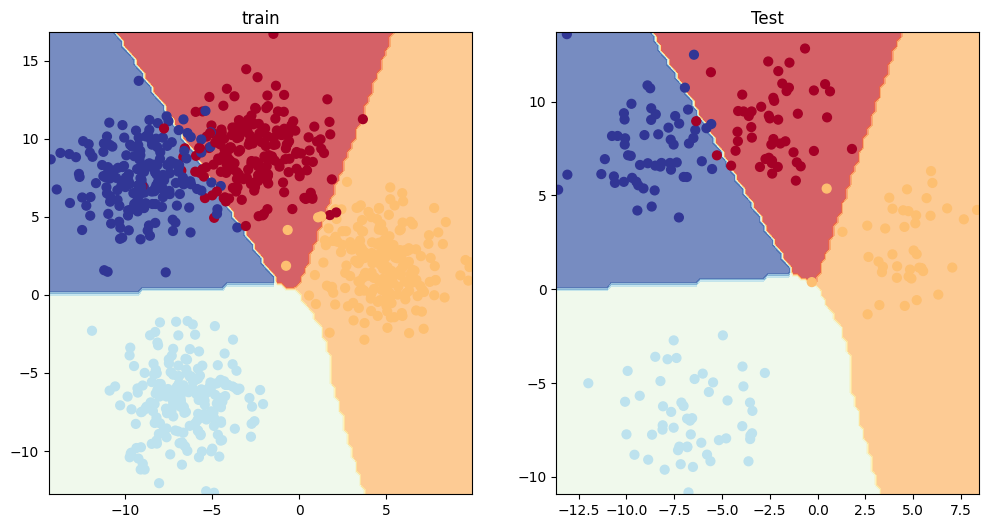

In [16]:
from helper_function import plot_decision_boundary
# plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_0, X_blob_train, y_blob_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_blob_test, y_blob_test)

tensor(0.9650)